In [1]:
import datetime


import numpy as np

import torch
import torch.nn.functional as F

from cogment_lab.envs.gymnasium import GymEnvironment
from cogment_lab.process_manager import Cogment
from cogment_lab.utils.coltra_utils import convert_trial_data_to_coltra
from cogment_lab.utils.runners import process_cleanup
from cogment_lab.utils.trial_utils import format_data_multiagent, concatenate

from coltra import HomogeneousGroup
from coltra.buffers import Observation, Action
from coltra.models import MLPModel
from coltra.policy_optimization import CrowdPPOptimizer

from cogment_lab.actors.nn_actor import ColtraActor

from tqdm import trange
import matplotlib.pyplot as plt


In [2]:
# Cleans up potentially hanging background processes from previous runs
process_cleanup()

Processes terminated successfully.


In [3]:
logpath = f"logs/logs-{datetime.datetime.now().isoformat()}"

cog = Cogment(log_dir=logpath)

print(logpath)

logs/logs-2023-12-13T20:12:44.394188


/Users/ariel/PycharmProjects/cogment_lab/venv/lib/python3.10/site-packages/cogment/context.py:213: UserWarning: No logging handler defined (e.g. logging.basicConfig)
  warnings.warn("No logging handler defined (e.g. logging.basicConfig)")


In [4]:
# We'll train on 

cenv = GymEnvironment(
    env_id="LunarLander-v2",
    render=True,
)

await cog.run_env(env=cenv, 
                  env_name="mcar",
                  port=9001, 
                  log_file="env.log")


True

In [5]:
# Create a model using coltra

model = MLPModel(
    config={
    "hidden_sizes": [64, 64],
    }, 
    observation_space=cenv.env.observation_space, 
    action_space=cenv.env.action_space
)

# Put the model in shared memory so that the actor can access it
model.share_memory()
actor = ColtraActor(model=model)


await cog.run_actor(
    actor=actor,
    actor_name="coltra",
    port=9021,
    log_file="actor.log"
)

True

In [6]:
# Check what's running

cog.processes

{'mcar': <SpawnProcess name='SpawnProcess-1' pid=18054 parent=18019 started>,
 'coltra': <SpawnProcess name='SpawnProcess-2' pid=18062 parent=18019 started>}

In [7]:
LUNAR_LANDER_ACTIONS = ["no-op", "ArrowRight", "ArrowUp", "ArrowLeft"]

actions = LUNAR_LANDER_ACTIONS

await cog.run_web_ui(actions=actions, log_file="human.log", fps=30)

True

In [8]:
# Estimate random agent performance

episodes = []
for i in trange(10):
    trial_id = await cog.start_trial(
        env_name="mcar",
        session_config={"render": False},
        actor_impls={
            "gym": "coltra",
        },
    )
    multi_data = await format_data_multiagent(datastore=cog.datastore, trial_id=trial_id, actor_agent_specs=cenv.agent_specs)
    data = multi_data["gym"]
    episodes.append(data)
mean_reward = np.mean([sum(e.rewards) for e in episodes])
print(f"mean_reward: {mean_reward}")

100%|██████████| 10/10 [00:01<00:00,  9.98it/s]

mean_reward: -52.153119627747216


In [10]:
# Reinitialize the agent

cog.stop_service("coltra")

model = MLPModel(
    config={
    "hidden_sizes": [64, 64],
    }, 
    observation_space=cenv.env.observation_space, 
    action_space=cenv.env.action_space
)

# Put the model in shared memory so that the actor can access it
model.share_memory()
actor = ColtraActor(model=model)


await cog.run_actor(
    actor=actor,
    actor_name="coltra",
    port=9021,
    log_file="actor.log"
)

True

In [11]:
# Get some human episodes
episodes = []
for i in range(3):
    trial_id = await cog.start_trial(
        env_name="mcar",
        session_config={"render": True},
        actor_impls={
            "gym": "web_ui",
        },
    )
    multi_data = await cog.get_trial_data(trial_id=trial_id)
    data = multi_data["gym"]
    episodes.append(data)
    
all_data = concatenate(episodes)

In [12]:
mean_reward = np.mean([sum(e.rewards) for e in episodes])
print(f"mean_reward: {mean_reward}")
print(f"rewards: {[sum(e.rewards) for e in episodes]}")

mean_reward: 77.66748484175616
rewards: [-90.41456591431051, 277.5436417415343, 45.87337869804469]


In [14]:
cog.stop_service("web_ui")

In [15]:
all_obs = Observation(vector=all_data.observations).tensor()
all_actions = torch.tensor(all_data.actions)

In [20]:
losses = []
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
for t in (pbar := trange(500)):
    preds = model(all_obs)[0].logits
    loss = F.cross_entropy(preds, all_actions)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    pbar.set_description(f"loss: {loss.item():.3}")
    
    losses.append(loss.item())
    

loss: 0.186: 100%|██████████| 500/500 [00:00<00:00, 738.80it/s]


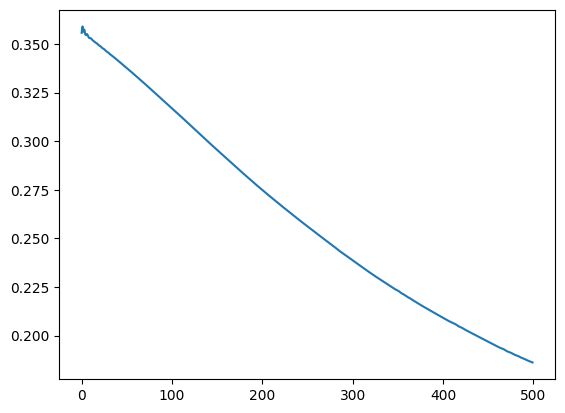

In [21]:
plt.plot(losses)

In [22]:
# Estimate agent performance

episodes = []
for i in trange(10):
    trial_id = await cog.start_trial(
        env_name="mcar",
        session_config={"render": False},
        actor_impls={
            "gym": "coltra",
        },
    )
    multi_data = await format_data_multiagent(datastore=cog.datastore, trial_id=trial_id, actor_agent_specs=cenv.agent_specs)
    data = multi_data["gym"]
    episodes.append(data)
mean_reward = np.mean([sum(e.rewards) for e in episodes])
print(f"mean_reward: {mean_reward}")

100%|██████████| 10/10 [00:02<00:00,  4.85it/s]

mean_reward: -93.20616755490191


mean_reward: 87.1: 100%|██████████| 100/100 [04:30<00:00,  2.70s/it]


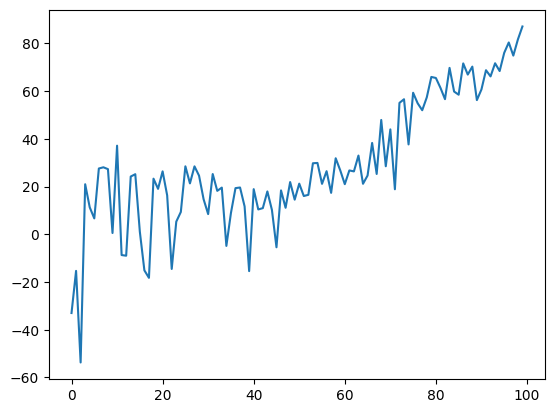

In [24]:
all_rewards = []

ppo = CrowdPPOptimizer(HomogeneousGroup(actor.agent), config={
    "gamma": 0.99,
    "gae_lambda": 0.95,
    "minibatch_size": 256,
})

for t in (pbar := trange(100)):
    num_steps = 0
    episodes = []
    while num_steps < 2000:
        trial_id = await cog.start_trial(
            env_name="mcar",
            session_config={"render": False},
            actor_impls={
                "gym": "coltra",
            },
        )
        multi_data = await format_data_multiagent(datastore=cog.datastore, trial_id=trial_id, actor_agent_specs=cenv.agent_specs)
        data = multi_data["gym"]
        episodes.append(data)
        num_steps += len(data.rewards)
        
    all_data = concatenate(episodes)
    
    record = convert_trial_data_to_coltra(all_data, actor.agent)
    metrics = ppo.train_on_data({"crowd": record}, shape=(1,) + record.reward.shape)
    
    mean_reward = metrics["crowd/mean_episode_reward"]
    all_rewards.append(mean_reward)
    pbar.set_description(f"mean_reward: {mean_reward:.3}")
        
plt.plot(all_rewards)


In [25]:
await cog.cleanup()